<a href="https://colab.research.google.com/github/MatiasCovarrubias/jaxecon/blob/main/jaxDEQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEQN Solver in Jax.

This notebook trains a neural net to output the optimal policy of a nonlinear Rbc model. This a single code implementation. For a more robust and modular implemenation, go to https://github.com/MatiasCovarrubias/jaxecon/tree/main/DEQN



In [1]:
GPU = True # set True if using GPU (only to see GPU)
if GPU:
  !nvidia-smi

# Imports
import matplotlib.pyplot as plt, jax, flax, optax, os, json
from jax import numpy as jnp, lax, random, config as jax_config
jax_config.update("jax_debug_nans", True)
import flax.linen as nn
from flax.training.train_state import TrainState  # Useful dataclass to keep train state
from flax.training import checkpoints
from flax.core import freeze, unfreeze
import optax
from time import time
from typing import Sequence


print(jax.devices())

# Mount Google Drive to store results (a pop up will appear, follow instructions)
from google.colab import drive
drive.mount('/content/drive')


/bin/bash: line 1: nvidia-smi: command not found
[CpuDevice(id=0)]
Mounted at /content/drive


## 0. Create Neural Net Policy

First, we use Flax to create the Neural Net, Notice that we activate the last layer using Softplus to guarantee that we get possitive outputs.

See https://flax.readthedocs.io/en/latest/getting_started.html

In [2]:
class NeuralNet(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.softplus(nn.Dense(self.features[-1])(x))
    return x

## 1. Create Economic Model

We will represent our model as a class with four main methods (or functions): initial_obs to get first observation; step to advance a period, expectation to get the expectation term given a state, policy, and shock; and a loss funciton that gets as the loss given a state, policy and expectation term.

In [3]:
class Model():
  """A JAX implementation of an RBC model."""

  def __init__(self):
    # set parameters
    self.beta = 0.985
    self.alpha = 0.3
    self.delta = 0.03
    self.rho = .9
    self.shock_sd = 0.01

    # set steady state and standard deviations for normalization
    self.k_ss = jnp.log((self.alpha/(1/self.beta-1+self.delta))**(1/(1-self.alpha)))
    self.a_ss = 0
    self.obs_ss = jnp.array([self.k_ss,self.a_ss])
    self.obs_sd = jnp.array([1,1])    # use 1 if you don't have an estimate
    self.policy_ss = jnp.log(self.delta*jnp.exp(self.k_ss))

    # number of policies
    self.n_actions = 1

  def initial_obs(self, rng):
    """ Get initial obs given first shock """
    rng_k, rng_a = random.split(rng,2)
    K = random.uniform(
        rng_k, minval=0.9*jnp.exp(self.k_ss), maxval=1.1*jnp.exp(self.k_ss)
        )                       # get uniform draw around the steady state
    A = random.uniform(
        rng_a, minval=0.9*jnp.exp(self.a_ss), maxval=1.1*jnp.exp(self.a_ss)
        )                       # get uniform draw around the steady state

    obs_init_notnorm = jnp.array([jnp.log(K),jnp.log(A)])
    obs_init = (obs_init_notnorm-self.obs_ss)/self.obs_sd # normalize
    return obs_init

  def step(self, obs, policy, shock):
    """ A period step of the model, given current obs, the shock and policy """

    obs_notnorm = obs*self.obs_sd + self.obs_ss                 # denormalize
    K = jnp.exp(obs_notnorm[0])                                 # Kt in levels
    a = obs_notnorm[1]                                          # a_{t}
    a_tplus1 = self.rho * a + self.shock_sd*shock[0]            # recover a_{t+1}
    policy_notnorm = policy*jnp.exp(self.policy_ss)             # multiply by stst pols in level
    K_tplus1 = (1-self.delta)*K + policy_notnorm[0]             #get K_{t+1}
    obs_next_notnorm = jnp.array([jnp.log(K_tplus1),a_tplus1])  #concatenate observation
    obs_next = (obs_next_notnorm-self.obs_ss)/self.obs_sd       # normalize

    return obs_next


  def expect_realization(self, obs_next, policy_next):
    """ A realization (given a shock) of the expectation terms in system of equation """

    policy_notnorm = policy_next*jnp.exp(self.policy_ss) # multiply by stst pols in levels
    I = policy_notnorm[0]                                # define investment

    # Process observation
    obs_notnorm = obs_next*self.obs_sd + self.obs_ss     # denormalize obs
    K = jnp.exp(obs_notnorm[0])                          # K_{t+1} in levels
    a = obs_notnorm[1]                                   # a_{t}

    # Rest of variables
    A = jnp.exp(a)
    Y = A * K**self.alpha
    C = Y-I

    # Calculate the FOC for Pk
    expect_realization = (1/C) * (1+ A * self.alpha * K**(self.alpha-1)-self.delta)

    return jax.lax.stop_gradient(expect_realization)

  def loss(self, obs, expect, policy):
    """ Calculate loss associated with observing obs, having policy_params, and expectation exp """

    policy_notnorm = policy*jnp.exp(self.policy_ss)
    I = policy_notnorm[0]

    # Process observation
    obs_notnorm = obs*self.obs_sd + self.obs_ss        # denormalize
    K = jnp.exp(obs_notnorm[0])                        # put in levels
    a = obs_notnorm[1]

    # Rest of variables
    A = jnp.exp(a)
    Y = A * K**self.alpha
    C = Y-I

    # Calculate the FOC for Pk
    FOC_loss = (1/C)/(self.beta*expect) - 1
    mean_loss = jnp.mean(jnp.array([FOC_loss**2])) # here there is just one, but more gemore generally.
    mean_accuracy = jnp.mean(jnp.array([1-jnp.abs(FOC_loss)]))
    min_accuracy = jnp.min(jnp.array([1-jnp.abs(FOC_loss)]))
    return mean_loss, mean_accuracy, min_accuracy

  def sample_shock(self, rng, n_draws=1):
    """ sample one realization of the shock.
    Uncomment second line for continuous shocks instead of grid """
    # return random.choice(rng, jnp.array([-1.2816,-0.6745,0,0.6745, 1.2816]))
    return random.normal(rng, shape=(n_draws,))

  def mc_shocks(self, rng=random.PRNGKey(0), mc_draws=8):
    """ sample omc_draws realizations of the shock (for monte-carlo)
    Uncomment second line for continuous shocks instead of grid """
    # return  jnp.array([-1.2816,-0.6745,0,0.6745, 1.2816])
    return random.normal(rng, shape=(mc_draws,1))

  def ir_shocks(self):
    """ (Optional) Define a set of shocks sequences that are of interest"""
    # ir_shock_1 = jnp.array([-1]+[0 for i in range(40)])
    # ir_shock_2 = jnp.array([1]+[0 for i in range(40)])
    ir_shock_1 = jnp.zeros(shape=(40,1)).at[0,:].set(-1)
    ir_shock_2 = jnp.zeros(shape=(40,1)).at[0,:].set(1)

    return jnp.array([ir_shock_1, ir_shock_2])

### Test the environment
We are going to make sure that the functions in our model are correct

In [ ]:
env = Model()
rng_test = random.PRNGKey(2)

# test steady state policies with random params
obs_ss = jnp.zeros_like(env.obs_ss)
nn_test = NeuralNet([2,2] + [env.n_actions])
nn_policy_test = nn_test.apply
params_test = nn_test.init(rng_test, obs_ss) # we initialize random params
policy_ss = nn_policy_test(params_test,obs_ss)
print("policy in steady state", policy_ss)

# intialize env
obs_init = env.initial_obs(rng_test)
print("initial obs", obs_init)

# apply a step
policy_firststep = nn_policy_test(params_test,obs_init)
print("policy in first step", policy_firststep)
shock_firststep = env.sample_shock(rng_test)
next_obs_firststep = env.step(obs_init, policy_firststep, shock_firststep)
print("next obs first step", next_obs_firststep)

# calculate loss in first step.

#First, we calculate expectations
mc_shocks = env.mc_shocks(rng_test)
mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs_init, policy_firststep, mc_shocks) # next obs given policy and for each shock in mc_shocks

mc_nextpols = nn_policy_test(params_test, mc_nextobs)
expect_firststep = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))

# Second, we calculate loss given expectations and policy
mean_loss, mean_accuracy, min_accuracy = env.loss(obs_init, expect_firststep, policy_firststep)
print("test epoch: \n",
      ", Mean_loss:", mean_loss,
      ", Mean_accuracy:", mean_accuracy,
      ", Min_accuracy:", min_accuracy)

# calculate loss with policy = 1
policy_ones = jnp.ones_like(policy_firststep)
mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs_ss, policy_ones, jnp.zeros_like(mc_shocks)) # next obs given policy and for each shock in mc_shocks
print("next obs for montecarlo with policies =1 (should be an array with multiple obs =0)", mc_nextobs)
mc_nextpols = jnp.ones_like(mc_nextpols)
expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
print("expectation", expect)
mean_loss, mean_accuracy, min_accuracy = env.loss(obs_ss, expect, policy_ones)
print("test that StSt. policies give 0 loss in StSt. obs: \n",
      ", Mean_loss:", mean_loss,
      ", Mean_accuracy:", mean_accuracy,
      ", Min_accuracy:", min_accuracy)


policy in steady state [0.6931472]
initial obs [ 0.03087664 -0.01336387]
policy in first step [0.6912521]
next obs first step [ 0.02093434 -0.01394364]
test epoch: 
 , Mean_loss: 4.9927676e-05 , Mean_accuracy: 0.99293405 , Min_accuracy: 0.99293405
next obs for montecarlo with policies =1 (should be an array with multiple obs =0) [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
expectation 0.563332
test that StSt. policies give 0 loss in StSt. obs: 
 , Mean_loss: 1.4210855e-14 , Mean_accuracy: 0.9999999 , Min_accuracy: 0.9999999


## 2. Create Training function
No we define a function specifying an entire epoch of learning. This is the minimal unti lfo computation that we wil compile and pass to all the devices (devices are sinchronized to average gradients).

In [4]:
def get_epoch_update_fn(env, config):
  """It runs and epoch with learning. This is what the compiler reads and parallelize."""

  def sample_epis_obs(train_state, epis_rng):
    "sample obs of an episode"
    env_obs = env.initial_obs(epis_rng)
    epis_rng, *period_rngs = random.split(epis_rng, config["periods_per_epis"]+1)
    def period_step(env_obs, period_rng):
      policy = train_state.apply_fn(train_state.params, env_obs)                 # calculate policy
      period_shock = config["simul_vol_scale"]*env.sample_shock(period_rng)         # Sample next obs
      obs_next = env.step(env_obs, policy, period_shock)  # apply period steps.
      return obs_next, obs_next # we pass it two times because of the syntax of the lax.scan loop
    _, epis_obs = lax.scan(period_step, env_obs, jnp.stack(period_rngs)) # we get the obs_batch
    return epis_obs

  def epis_loss_fn(params, nn_policy, epis_rng, obs_batch):
    """Loss function of an episode, which has periods_per_epis time periods."""
    epis_rng, *period_mc_rngs = random.split(epis_rng, config["periods_per_epis"]+1)
    policies_batch = nn_policy(params, obs_batch) # get the policies for the entire obs batch.

    def period_loss(obs, policy, period_mc_rng):
      """Loss function for an individual period."""
      mc_shocks = env.mc_shocks(period_mc_rng, config["mc_draws"])
      mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs, policy, mc_shocks)
      mc_nextpols = nn_policy(params, mc_nextobs)
      expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
      mean_loss, mean_accuracy, min_accuracy = env.loss(obs, expect, policy) # calculate loss
      return mean_loss, mean_accuracy, min_accuracy

    # parallelize calculation of period_loss for the entire batch
    mean_losses, mean_accuracies, min_accuracies = jax.vmap(period_loss)(obs_batch, policies_batch, jnp.stack(period_mc_rngs))
    mean_loss = jnp.mean(mean_losses)                   # average accross periods
    mean_accuracy = jnp.mean(mean_accuracies)           # average accross periods
    min_accuracy = jnp.min(min_accuracies)              # min accross periods and across eqs within period
    metrics = jnp.array([mean_loss, mean_accuracy, min_accuracy]) # pass as auxiliary info
    return mean_loss, metrics

  def step_loss_fn(params, nn_policy, epis_rng, step_obs):
    mean_losses, step_metrics = jax.vmap(epis_loss_fn,in_axes = (None,None,0,0))(
        params, nn_policy, jnp.stack(epis_rng), step_obs)
    mean_loss = jnp.mean(mean_losses)
    step_metrics = jnp.mean(step_metrics,axis=0)
    return mean_loss, step_metrics

  def step_update_fn(train_state, step_rng):
    """Compute a gradient update from a single episode."""
    step_rng, *epis_rng = random.split(step_rng, config["epis_per_step"]+1)
    step_obs = jax.vmap(sample_epis_obs, in_axes = (None,0))(train_state, jnp.stack(epis_rng))
    grads, step_metrics  = jax.grad(step_loss_fn, has_aux=True)(
        train_state.params, train_state.apply_fn, epis_rng, step_obs)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, step_metrics

  def epoch_update_fn(train_state, epoch_rng):
    """Vectorise and repeat the update to complete an epoch, made out of steps_per_epoch episodes."""
    epoch_rng, *step_rngs = random.split(epoch_rng, config["steps_per_epoch"]+1)
    train_state, epoch_metrics = lax.scan(step_update_fn, train_state, jnp.stack(step_rngs))
    return train_state, epoch_rng, epoch_metrics

  return epoch_update_fn

### Test the update function

We can run one epoch and see the results. Play with the parameters of the epoch to evaluate how good is the starting point. You can also add prints inside the update function to check internal values. An important check is to print the grads inside the epis_update_fn and make sure they are not zero for an entire layer. This is especially relevant when using pre-trained models.

In [ ]:
# CREATE MODEL AND GET UPDATE FUNCTION
config_test = {
    "periods_per_epis": 16,      # periods per episode
    "epis_per_step": 4,          # epoch per steps
    "steps_per_epoch": 100,      # steps per epoch
    "n_epochs": 1,               # number of epochs
    "mc_draws": 32,              # only applies if shock is continuous
    "simul_vol_scale": 1.5,      # scale of volatility while simul
}

env_test = Model()
epoch_update_test = get_epoch_update_fn(env_test, config_test)

#CREATE TRAIN_STATE AND RNG
nn_test = NeuralNet([2,2] + [env_test.n_actions])
rng_test = random.PRNGKey(1)
train_state_test = TrainState.create(apply_fn=nn_test.apply, params=nn_test.init(rng_test, env_test.initial_obs(rng_test)), tx=optax.adam(0.05))

# RUN UPDATE FUNCTION
new_train_state, new_rng_test, metrics_test = epoch_update_test(train_state_test, rng_test)
print("test epoch: \n",
      "Mean_loss:", metrics_test[:,0], "\n",
      "Mean_accuracy:", metrics_test[:,1], "\n",
      "Min_accuracy:", metrics_test[:,2],)


test epoch: 
 Mean_loss: [1.52172186e-04 5.46795054e-05 4.95281092e-05 2.28700483e-05
 8.22657166e-05 4.06773761e-05 8.45190953e-05 7.63606804e-05
 5.12300103e-05 9.08388029e-05 4.62097087e-05 7.78444883e-05
 5.92431279e-05 6.88237706e-05 3.91675785e-05 2.86410577e-05
 4.69407460e-05 5.63513131e-05 4.90620405e-05 6.30773793e-05
 3.76253192e-05 7.70917759e-05 1.01072284e-04 1.59696265e-05
 3.01137516e-05 7.12421897e-05 3.05538560e-05 6.02270666e-05
 3.61642560e-05 3.09724346e-05 7.25238060e-05 2.46877571e-05
 3.00298798e-05 7.98231704e-05 5.15359352e-05 6.74681069e-05
 4.56958696e-05 1.17251395e-04 4.67855316e-05 5.00945171e-05
 9.08610818e-05 6.98063450e-05 7.55568472e-05 6.64680992e-05
 3.54782351e-05 7.56452937e-05 5.39993271e-05 4.20127981e-05
 5.87231189e-05 5.25197684e-05 5.09004894e-05 7.36846778e-05
 2.77534837e-05 3.82455946e-05 5.42830312e-05 3.96968244e-05
 3.95177849e-05 4.50413863e-05 2.60469424e-05 9.60033358e-05
 3.85839739e-05 6.02689543e-05 3.76908793e-05 7.68312748e-05

## 4. Configure experiment

Number of parameters:

                           NeuralNet Summary                            
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs     ┃ outputs    ┃ params               ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│         │ NeuralNet │ float32[2] │ float32[1] │                      │
├─────────┼───────────┼────────────┼────────────┼──────────────────────┤
│ Dense_0 │ Dense     │ float32[2] │ float32[2] │ bias: float32[2]     │
│         │           │            │            │ kernel: float32[2,2] │
│         │           │            │            │                      │
│         │           │            │            │ 6 (24 B)             │
├─────────┼───────────┼────────────┼────────────┼──────────────────────┤
│ Dense_1 │ Dense     │ float32[2] │ float32[2] │ bias: float32[2]     │
│         │           │            │            │ kernel: float32[2,2] │
│         │           │     

Text(0, 0.5, 'Learning Rate')

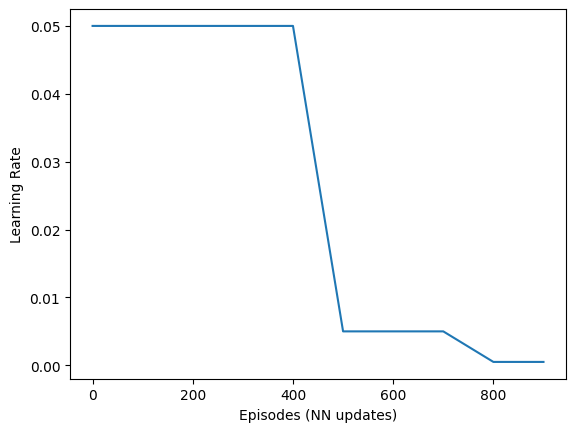

In [5]:
'''Config dictionary'''

# CREATE LEARNING RATE SCHEDULE (https://github.com/google-deepmind/optax/blob/master/optax/_src/schedule.py)
lr_schedule = optax.join_schedules(
      schedules= [optax.constant_schedule(0.05),
                  optax.constant_schedule(0.005),
                  optax.constant_schedule(0.0005)],
      boundaries=[500,750] # the number of episodes at which to switch

      )

# CREATE CONFIG DICT
config = {
    "periods_per_epis": 128,      # periods per episode
    "epis_per_step": 4,           # epoch per steps
    "steps_per_epoch": 100,       # steps per epoch
    "n_epochs": 10,               # number of epochs
    "mc_draws": 32,               # only applies if shock is continuous
    "simul_vol_scale": 1.5,       # scale of volatility while simul
    "layers": [2,2],              # layers of the NN
    "learning_rate": lr_schedule, # learning rate schedule
    "seed": 48,                   # random seed, set to whatever int.
    "run_name": "rbc_Dec30_ly2x2mc32ppe128eps4",
    "date": "December_30",
    "working_dir": "/content/drive/MyDrive/Jaxecon/Rbc/Training/" # replace with your folder
}

# PRINT AND PLOT KEY CONFIGS
print("Number of parameters:")
print(NeuralNet(config["layers"] + [Model().n_actions]).tabulate(
    random.PRNGKey(0),
    Model().initial_obs(random.PRNGKey(0))
    ))

print("Number of steps (NN updates): \n", config["steps_per_epoch"]*config["n_epochs"], "episodes \n")

print("Learning rate schedule:")
plt.plot(
    [i*config["steps_per_epoch"] for i in range(config["n_epochs"])],
    [config["learning_rate"](i*config["steps_per_epoch"]) for i in range(config["n_epochs"])]
    )
plt.xlabel('Episodes (NN updates)')
plt.ylabel('Learning Rate')

## 5. Create and Run experiment
Now we the entire experiment workflow as a function to call later.

In [6]:
def run_experiment(env, config):
  """Runs experiment."""

  n_cores = len(jax.devices())  # get available TPU cores.

  # CREATE NN, RNGS, TRAIN_STATE AND EPOQUE UPDATE
  nn = NeuralNet(config["layers"] + [env.n_actions])
  rng, rng_pol, rng_env, rng_epoch = random.split(random.PRNGKey(config["seed"]), num=4)  # random number generator
  train_state = TrainState.create(apply_fn=nn.apply, params=nn.init(rng_pol, env.initial_obs(rng_env)), tx=optax.adam(config["learning_rate"]))
  epoch_update = jax.jit(get_epoch_update_fn(env, config))

  # COMPILE CODE
  time_start = time()
  epoch_update(train_state, rng_epoch)  # compiles
  time_compilation = time() - time_start
  print("Time Elapsed for Compilation:", time_compilation, "seconds")

  # RUN AN EPOCH TO GET TIME STATS
  time_start = time()
  epoch_update(train_state, rng_epoch) # run one epoque
  time_epoch = time() - time_start
  print("Time Elapsed for epoch:", time_epoch, "seconds")
  print("Steps per second:",
        n_cores*config["steps_per_epoch"]*config["epis_per_step"]*config["periods_per_epis"]/time_epoch, "st/s")

  # CREATE LISTS TO STORE METRICS
  mean_losses, mean_accuracy, min_accuracy = [], [], []

  # RUN ALL THE EPOCHS
  time_start = time()
  for i in range(1,config["n_epochs"]+1):
    train_state, rng_epoch, epoch_metrics = epoch_update(train_state, rng_epoch)

    mean_losses.append(float(jnp.mean(epoch_metrics[:,0])))
    mean_accuracy.append(float(jnp.mean(epoch_metrics[:,1])))
    min_accuracy.append(float(jnp.min(epoch_metrics[:,2])))

    print('Iteration:', i*config["steps_per_epoch"],
          ", Mean_loss:", jnp.mean(epoch_metrics[:,0]),
          ", Mean_accuracy:", jnp.mean(epoch_metrics[:,1]),
          ", Min_accuracy:", jnp.min(epoch_metrics[:,2]),
          ", Learning rate:", config["learning_rate"](i*config["steps_per_epoch"]),
          "\n"
          )

  # STORE RESULTS
  print("Minimum loss attained in training:", min(mean_losses))
  print("Maximum mean accuracy attained in training:", max(mean_accuracy))
  print("Maximum min accuracy attained in training:", max(min_accuracy))

  time_fullexp = (time() - time_start)/60
  print("Time Elapsed for Full Experiment:", time_fullexp, "minutes")

  results = {
      "min_loss":  min(mean_losses),
      "max_mean_acc": max(mean_accuracy),
      "max_min_acc": max(min_accuracy),
      "Time for Full Experiment (m)": time_fullexp,
      "Time for epoch (s)": time_epoch,
      "Time for Compilation (s)": time_compilation,
      "Steps per second": n_cores * config["steps_per_epoch"] * config["periods_per_epis"]/time_epoch,
      "n_cores": n_cores,
      "periods_per_epis": config["periods_per_epis"],
      "epis_per_step": config["epis_per_step"],
      "steps_per_epoch": config["steps_per_epoch"],
      "n_epochs": config["n_epochs"],
      "mc_draws": config["mc_draws"],
      "layers": config["layers"],
      "date": config["date"],
      "seed": config["seed"],
      "Losses_list": mean_losses,
      "mean_accuracy_list": mean_accuracy,
      "min_accuracy_list": min_accuracy,
  }

  if not os.path.exists(config['working_dir']+config['run_name']):
    os.mkdir(config['working_dir']+config['run_name'])
  with open(config['working_dir']+config['run_name']+"/results.json", "w") as write_file:
    json.dump(results, write_file)

  # store checkpoint
  checkpoints.save_checkpoint(ckpt_dir=config['working_dir']+config['run_name'], target=train_state, step=config["n_epochs"]*config["steps_per_epoch"])

  # PLOT LEARNING

  # Mean Losses
  plt.plot([(i)*config["steps_per_epoch"] for i in range(len(mean_losses))], mean_losses)
  plt.xlabel('Episodes (NN updates)')
  plt.ylabel('Mean Losses')
  plt.savefig(config['working_dir']+config['run_name']+'/mean_losses.jpg')
  plt.close()

  # Mean Accuracy
  plt.plot([(i)*config["steps_per_epoch"] for i in range(len(mean_accuracy))], mean_accuracy)
  plt.xlabel('Episodes (NN updates)')
  plt.ylabel('Mean Accuracy (%)')
  plt.savefig(config['working_dir']+config['run_name']+'/mean_accuracy.jpg')
  plt.close()

  # Min Accuracy
  plt.plot([(i)*config["steps_per_epoch"] for i in range(len(min_accuracy))], min_accuracy)
  plt.xlabel('Episodes (NN updates)')
  plt.ylabel('Minimum Accuracy (%)')
  plt.savefig(config['working_dir']+config['run_name']+'/min_accuracy.jpg')
  plt.close()

  # Learning rate schedule
  plt.plot([i*config["steps_per_epoch"] for i in range(len(mean_losses))], [config["learning_rate"](i*config["steps_per_epoch"]) for i in range(len(mean_losses))])
  plt.xlabel('Episodes (NN updates)')
  plt.ylabel('Learning Rate')
  plt.savefig(config['working_dir']+config['run_name']+'/learning_rate.jpg')
  plt.close()

  return train_state

Fimally, we run the experiment and get the trained parameter plus useful info.

In [7]:
final_train_state = run_experiment(Model(), config)

# DISCONNECT SESSION (uncomment next 2 lines if you do large run)
# from google.colab import runtime
# runtime.unassign()

Time Elapsed for Compilation: 6.218074560165405 seconds
Time Elapsed for epoch: 0.18366432189941406 seconds
Steps per second: 278769.4391077233 st/s
Iteration: 100 , Mean_loss: 1.2683235e-05 , Mean_accuracy: 0.9979832 , Min_accuracy: 0.97128725 , Learning rate: 0.05 

Iteration: 200 , Mean_loss: 5.292878e-07 , Mean_accuracy: 0.99957484 , Min_accuracy: 0.99041706 , Learning rate: 0.05 

Iteration: 300 , Mean_loss: 3.8755985e-07 , Mean_accuracy: 0.9995843 , Min_accuracy: 0.99149275 , Learning rate: 0.05 

Iteration: 400 , Mean_loss: 3.2663579e-07 , Mean_accuracy: 0.9995895 , Min_accuracy: 0.9949913 , Learning rate: 0.05 

Iteration: 500 , Mean_loss: 3.5850175e-07 , Mean_accuracy: 0.9995828 , Min_accuracy: 0.99207985 , Learning rate: 0.005 

Iteration: 600 , Mean_loss: 3.236997e-07 , Mean_accuracy: 0.99959135 , Min_accuracy: 0.994445 , Learning rate: 0.005 

Iteration: 700 , Mean_loss: 3.3725394e-07 , Mean_accuracy: 0.999588 , Min_accuracy: 0.9939214 , Learning rate: 0.005 

Iteration: 80

## 6. Simulate

Observations Quantiles (10%,25%,50%,75%,90%) [[-0.04018307 -0.02931404]
 [-0.02144587 -0.01500161]
 [-0.00150549  0.00028353]
 [ 0.01804399  0.0155461 ]
 [ 0.0353108   0.02872955]]
Minimum Accuracy 0.99835885
Accuracies Quantiles (10%,25%,50%,75%,90%) [0.9996592  0.9997582  0.9998561  0.99993134 0.99997276]


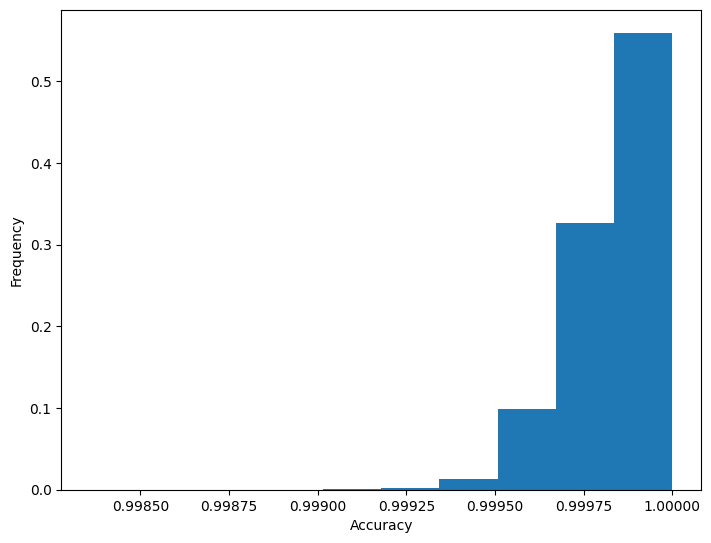

In [8]:
# CONFIG SIMUL FUNCTION
config_simul = {
    "periods": 10000,              # periods per episode
    "mc_draws": 256,               # only applies if shock is continuous
}

# CREATE SIMUL FUNCTION
def get_simul_fn(env, config):

  def sample_simul_obs(train_state, epis_rng):
    "sample obs of an episode"
    env_obs = jnp.zeros_like(env.obs_ss)
    epis_rng, *period_rngs = random.split(epis_rng, config["periods"]+1)
    def period_step(env_obs, period_rng):
      policy = train_state.apply_fn(train_state.params, env_obs)                 # calculate policy
      period_shock = env.sample_shock(period_rng)         # Sample next obs
      obs_next = env.step(env_obs, policy, period_shock)  # apply period steps.
      return obs_next, obs_next # we pass it two times because of the syntax of the lax.scan loop
    _, epis_obs = lax.scan(period_step, env_obs, jnp.stack(period_rngs)) # we get the obs_batch
    return epis_obs

  def simul_loss(params, nn_policy, epis_rng, obs_batch):
    """Loss function of an episode, which has periods_per_epis time periods."""
    epis_rng, *period_mc_rngs = random.split(epis_rng, config["periods"]+1)
    policies_batch = nn_policy(params, obs_batch) # get the policies for the entire obs batch.

    def period_loss(obs, policy, period_mc_rng):
      """Loss function for an individual period."""
      mc_shocks = env.mc_shocks(period_mc_rng, config["mc_draws"])
      mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs, policy, mc_shocks)
      mc_nextpols = nn_policy(params, mc_nextobs)
      expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
      mean_loss, mean_accuracy, min_accuracy = env.loss(obs, expect, policy) # calculate loss
      return mean_loss, mean_accuracy, min_accuracy

    # parallelize callculation of period_loss for the entire batch
    mean_losses, mean_accuracies, min_accuracies = jax.vmap(period_loss)(obs_batch, policies_batch, jnp.stack(period_mc_rngs))
    return mean_losses, mean_accuracies, min_accuracies

  def simul_fn(train_state, epis_rng):
    """Get obs for simul and then calculate loss function"""
    simul_obs = sample_simul_obs(train_state, epis_rng)
    _, simul_accuracies, _  = simul_loss(train_state.params, train_state.apply_fn, epis_rng, simul_obs)
    return simul_obs, simul_accuracies

  return simul_fn

# RUN SIMUL
rng_simul = random.PRNGKey(1)
env_simul = Model()
simul_fn = jax.jit(get_simul_fn(env_simul, config_simul))
simul_obs, simul_accuracies = simul_fn(final_train_state, rng_simul)

# GET STATISTICS
obs_quantiles = jnp.quantile(simul_obs, jnp.array([0.1,0.25,0.5,0.75,0.9]), axis=0)
acc_quantiles = jnp.quantile(simul_accuracies, jnp.array([0.1,0.25,0.5,0.75,0.9]))
print('Observations Quantiles (10%,25%,50%,75%,90%)', obs_quantiles)
print('Minimum Accuracy', jnp.min(simul_accuracies))
print('Accuracies Quantiles (10%,25%,50%,75%,90%)', acc_quantiles)

# HISTOGRAM OF ACCURACIES
counts, bins = jnp.histogram(simul_accuracies)
freqs = counts/config_simul["periods"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.hist(bins[:-1], bins, weights=freqs)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
# plt.show
fig.savefig(config['working_dir']+config['run_name']+'/acurracy_hists.jpg', bbox_inches="tight", pad_inches=1)


## 7. Evaluate Accuracy of MC Estimation

{'error_1_draws': Array(0.00123086, dtype=float32), 'error_4_draws': Array(0.00052709, dtype=float32), 'error_16_draws': Array(0.00033456, dtype=float32), 'error_64_draws': Array(0.00014887, dtype=float32), 'error_256_draws': Array(7.780886e-05, dtype=float32)}
[0.0012308551231399179, 0.0005270869005471468, 0.0003345642180647701, 0.00014886827557347715, 7.78088578954339e-05]


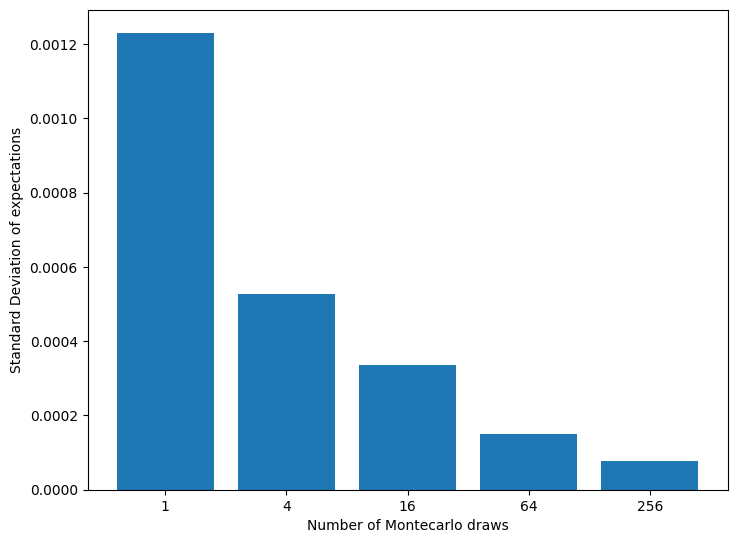

In [9]:
# evaluate montecarlo estimation of expectation
env = Model()
rng_mc = random.PRNGKey(0)
params_test = final_train_state.params # Choose parameteres to test
nn_policy_test = final_train_state.apply_fn

def get_expectation_fn(nn_policy, params, env):
  def expectation(n_draws, rng,  obs):
    policy = nn_policy(params, obs)
    mc_obs = env.mc_shocks(rng, mc_draws=n_draws)
    mc_nextobs = jax.vmap(env.step, in_axes=(None, None,0))(obs, policy, mc_obs)
    mc_nextpols = nn_policy(params,jnp.stack(mc_nextobs))
    exp = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
    return exp
  return expectation

rng_mc, *mc_rngs = jax.random.split(rng_mc, 100 + 1)

# obs_list = list(obs_quantiles)
obs_list = [env.initial_obs(rng_mc)]
n_draws_list = [1,4,16,64,256]
# n_draws_list = [500, 1000]
rng_list =list(mc_rngs)

mc_explist = {n_draws_list[i]: [] for i in range(len(n_draws_list))}
mc_error = {f"error_{n_draws_list[i]}_draws": [] for i in range(len(n_draws_list))}
for i in range(len(n_draws_list)):
  for j in range(len(rng_list)):
    for k in range(len(obs_list)):
      # exp_jitted = jax.jit(get_expectation_fn(nn_forward, params, env)).lower(n_draws_list[i], rng_list[j], obs_list[k]).compile
      mc_explist[n_draws_list[i]].append(get_expectation_fn(nn_policy_test, params_test, env)(n_draws_list[i], rng_list[j],  obs_list[k]))
      # mc_eval[(i,j,k)] = exp_jitted(n_draws_list[i], rng_list[j],  obs_list[k])
  mc_error[f"error_{n_draws_list[i]}_draws"] = jnp.std(jnp.array(mc_explist[n_draws_list[i]]))
print(mc_error)

error_list = [float(mc_error[f"error_{n_draws_list[i]}_draws"]) for i in range(len(n_draws_list))]
print(error_list)
n_drawsstr_list = [str(n_draws_list[i]) for i in range(len(n_draws_list))]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(n_drawsstr_list, error_list)
plt.xlabel('Number of Montecarlo draws')
plt.ylabel('Standard Deviation of expectations')
# plt.show
fig.savefig(config['working_dir']+config['run_name']+'/mc_eval.jpg', bbox_inches="tight", pad_inches=1)


## 8. Impulse Responses

shape of ir shocks: (2, 40, 1)


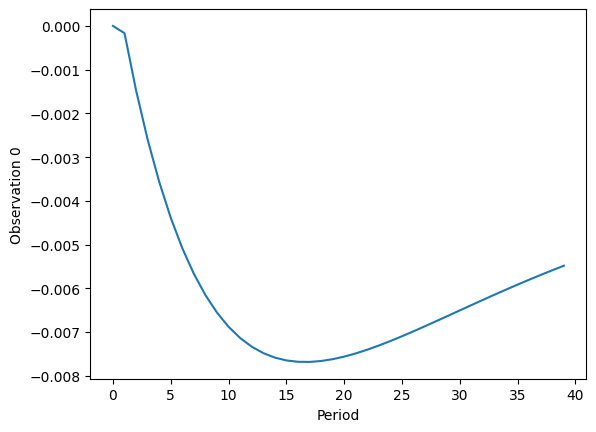

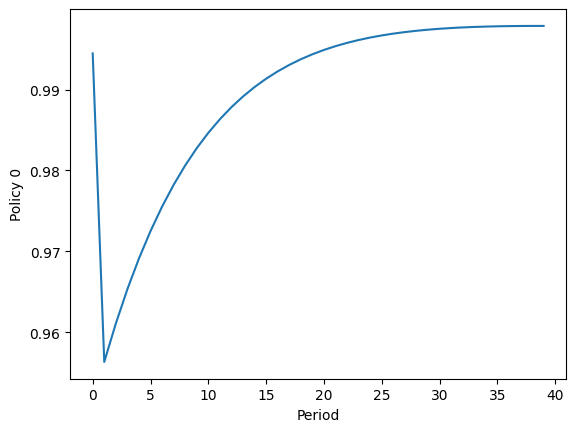

In [10]:
# Impulse responses of dynare policy vs learned policy
env = Model()

ir_shocks = env.ir_shocks()
print("shape of ir shocks:", ir_shocks.shape)

def ir(env, train_state, shocks):
  def step(obs, shock):
    policy = train_state.apply_fn(train_state.params, obs)
    next_obs = env.step(obs, policy, shock)
    obs_pol_pair = (obs,policy)
    return next_obs, obs_pol_pair
  obs_init = jnp.zeros_like(env.obs_ss)
  final_obs, obs_pol_pairs = lax.scan(step, obs_init, shocks)
  return final_obs, obs_pol_pairs

ir_final_obs, ir_obs_pol_pairs = jax.vmap(ir, in_axes = (None,None,0))(env, final_train_state, ir_shocks)
ir_obs, ir_policy = ir_obs_pol_pairs

# PLOT
ir_index = 0 # choose the IR exercise
obs_index = 0 # choose the obs to plot
obs_label = f"Observation {obs_index}" # create label
policy_index = 0 # choose the policy to plot
policy_label = f"Policy {policy_index}" # create label
# plot obs
plt.plot(list(range(40)), ir_obs[ir_index,:,obs_index], label ="observation")
plt.savefig(config['working_dir']+config['run_name']+'/IRobs.jpg')
plt.xlabel("Period")
plt.ylabel(obs_label)
plt.show()
#plot policy
plt.plot(list(range(40)), ir_policy[0,:,policy_index], label ="policy")
plt.savefig(config['working_dir']+config['run_name']+'/IRpolicy.jpg')
plt.xlabel("Period")
plt.ylabel(policy_label)
plt.show()
